# RoboTT Dataset

The dataset was used for lot date detection on medication packaging.  
It is not publicly available and the associated code is here for the sake of maintenance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import re
import csv
import traceback
import pickle
from scipy.ndimage.filters import gaussian_filter

from ssd_viz import plot_box

### Preprocessing and Augmentation

   1 2anno/BoxLotDate_MP-82198-003-01-GR-001.jpg


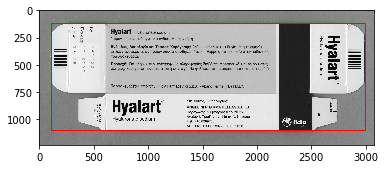

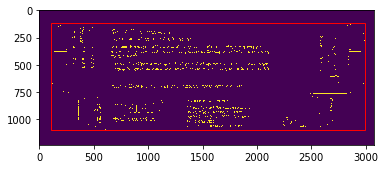

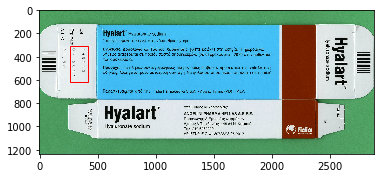

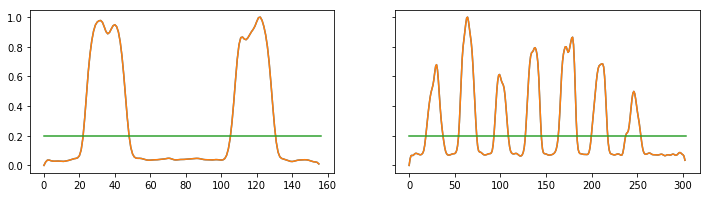

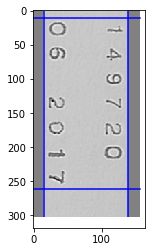

0 90
[[280 323]
 [403 573]]


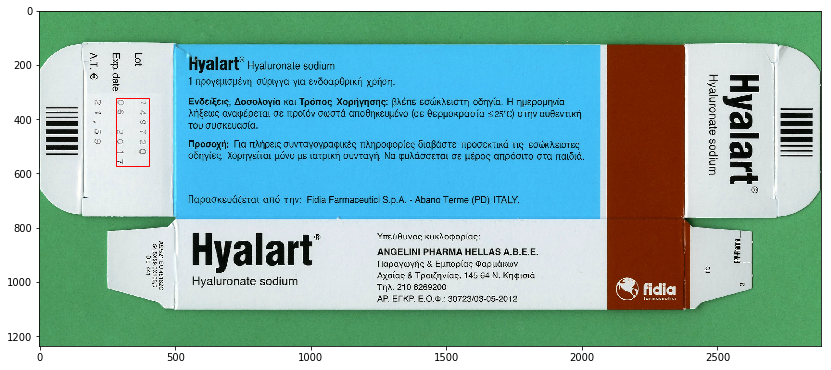

In [13]:
data_path = './data/RoboTT/'
output_path = './data/RoboTT_extra/'

window_length = 8
threshold = 0.2
padding = 8

wh = int(window_length/2)
win = np.hanning(window_length)

j = 0
for filename in glob.glob(data_path+'**/*_location.csv', recursive=True):
    j += 1
    
    #k = 2200
    #k = 2800
    #k = 3073
    #k = 236
    #if j < k: continue
    #if j > k+30: break
    if j > 1: break
    
    image_path = re.sub(r'_location\.csv$', '.jpg', filename)
    image_name = image_path[len(data_path):]
    with open(filename, newline='') as f:
        reader = csv.reader(f, delimiter=';')
        header = next(reader)
        box = next(reader, None)
        if box:
            print('%4d'%j, image_name)
            img = cv2.imread(image_path)
            img_width, img_height, _ = img.shape
            
            try:
                # crop background
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (7,7), 0)
                edges = cv2.Canny(blur, 100, 200)
                xmin, ymin, w, h = crop_box = cv2.boundingRect(cv2.findNonZero(edges))
                xmax, ymax = xmin + w, ymin + h
                
                if h < w:
                    b = int((w - h) / 2)
                    ymin = max(ymin-b, 0)
                    ymax = min(ymax+b, img_width)
                else:
                    b = int((h - w) / 2)
                    xmin = max(xmin-b, 0)
                    xmax = min(xmax+b, img_height)
                
                cropped = np.copy(img[ymin:ymax, xmin:xmax])
                
                bounding_box = np.array([box[2], box[1], box[4], box[3]], dtype=float) 
                bounding_box -= [xmin, ymin, xmin, ymin]
                bounding_box[0::2] = np.clip(bounding_box[0::2], 0, xmax)
                bounding_box[1::2] = np.clip(bounding_box[1::2], 0, ymax)
                bounding_box = np.round(bounding_box).astype(int)
                xmin_b, ymin_b, xmax_b, ymax_b = bounding_box
                
                # debug
                if True:
                    plt.imshow(gray, cmap='gray')
                    plot_box(crop_box)
                    plt.show()
                    plt.imshow(edges)
                    plot_box(crop_box)
                    plt.show()
                    plt.imshow(cropped)
                    plot_box(bounding_box, box_format='xyxy')
                    plt.show()

                # crop ground truth box
                im2 = cropped[ymin_b:ymax_b, xmin_b:xmax_b]
                im2 = im2.dot([0.299, 0.587, 0.114])
                im2 = im2 - np.min(im2)
                im2 = im2 / np.max(im2) * 255
                
                # sharpening, adding an approximation of the laplacian
                blurred = gaussian_filter(im2, 1)
                im2 = im2 + 5 * (im2 - blurred)
                
                im2 = gaussian_filter(im2, 1)
                
                def norm_signal(s):
                    s = s - min(s)
                    s = s / max(s)
                    return s
                
                def calc_min_max(img, axis=0):
                    #threshold_h = max(0.6 - img.shape[1]/500, 0.2)
                    s = np.sum(np.abs(np.diff(img, axis=axis)), axis=axis)
                    s = np.convolve(win/win.sum(), s, mode='same')
                    s = norm_signal(s)
                    sp = np.copy(s)
                    
                    try:
                        bn = np.argwhere(np.array(s <= threshold))[:,0]
                        if s[0] > threshold and bn[0] < len(s) * 0.3:
                            s[0:bn[0]] = 0
                            b = np.argwhere(np.array(s > threshold))[:,0]
                            s[0:b[0]] = 0
                        if s[-1] > threshold and bn[-1] > len(s) * (1-0.3):
                            s[bn[-1]:] = 0
                            b = np.argwhere(np.array(s > threshold))[:,0]
                            s[0:b[0]+1] = 0
                    except Exception as e:
                        print('ERROR')
                        print(traceback.format_exc())
                        #print(s)
                        #print(b)
                        s = sp
                    
                    s = norm_signal(s)
                    b = np.argwhere(np.array(s > threshold))[:,0]
                    
                    try:
                        crop_min = b[0] - padding
                        crop_max = b[-1] + padding
                    except Exception as e:
                        print('ERROR')
                        print(traceback.format_exc())
                        print(s)
                        print(b)
                    
                    return s, sp, crop_min, crop_max
                
                if im2.shape[1] < im2.shape[0]:
                    s3, s3p, xmin_new_loc, xmax_new_loc = calc_min_max(im2, axis=0)
                    im2[:,:max(0,xmin_new_loc)] = 127
                    im2[:,max(0,xmax_new_loc):] = 127
                    s4, s4p, ymin_new_loc, ymax_new_loc = calc_min_max(im2, axis=1)
                else:
                    s4, s4p, ymin_new_loc, ymax_new_loc = calc_min_max(im2, axis=1)
                    im2[:max(0,ymin_new_loc),:] = 127
                    im2[max(0,ymax_new_loc):,:] = 127
                    s3, s3p, xmin_new_loc, xmax_new_loc = calc_min_max(im2, axis=0)
                    
                xy = np.array([[xmin_b+xmin_new_loc, ymin_b+ymin_new_loc],[xmin_b+xmax_new_loc, ymin_b+ymax_new_loc]])

                # debug
                if True:
                    fig, axs = plt.subplots(1, 2, figsize=(12,3), sharey=True)
                    axs[0].plot(s3)
                    axs[0].plot(s3p)
                    axs[0].plot([0, len(s3)], [threshold, threshold])
                    axs[1].plot(s4)
                    axs[1].plot(s4p)
                    axs[1].plot([0, len(s4)], [threshold, threshold])
                    plt.show()

                    plt.imshow(im2, cmap='gray')
                    #plt.vlines(b, 0, 100, 'r')
                    plt.vlines([xmin_new_loc, xmax_new_loc], 0, im2.shape[0], 'b')
                    plt.plot([0, len(s3)], [ymin_new_loc, ymin_new_loc], 'b')
                    plt.plot([0, len(s3)], [ymax_new_loc, ymax_new_loc], 'b')
                    plt.show()


                # augment by rotating in all four orientations
                orientations = ['0', '90', '180', '-90']
                orientation_idx = orientations.index(box[0])

                image_name_split = os.path.splitext(os.path.split(image_name)[-1])
                base_path = os.path.join(output_path, image_name_split[0])

                for i in range(4):
                    # ground truth
                    xmin_b = np.min(xy[:,0])
                    ymin_b = np.min(xy[:,1])
                    xmax_b = np.max(xy[:,0])
                    ymax_b = np.max(xy[:,1])
                    box = [orientations[orientation_idx], ymin_b, xmin_b, ymax_b, xmax_b]

                    # save files
                    out_idx = orientation_idx + 1
                    out_image_path = base_path + '_rotated%d.jpg' % (out_idx,)
                    out_csv_path = base_path + '_rotated%d_location.csv' % (out_idx,)

                    cv2.imwrite(out_image_path, cropped)
                    with open(out_csv_path, 'w', newline='') as f:
                        writer = csv.writer(f, delimiter=';', quoting=csv.QUOTE_MINIMAL)
                        writer.writerow(header)
                        writer.writerow(box)

                    # debug
                    if True:
                        print(i, orientations[orientation_idx])
                        print(xy)

                        plt.figure(figsize=[14]*2)
                        plt.imshow(cropped)
                        ax = plt.gca()
                        d = xy[1,:] - xy[0,:]
                        rect = plt.Rectangle(xy[0,:], d[0], d[1], linewidth=1, edgecolor='r', facecolor='none')
                        ax.add_patch(rect)
                        plt.show()
                        break

                    if i == 3:
                        break

                    # rotate by 90 degree
                    cropped = np.rot90(cropped, 1)
                    h_cropped, w_cropped = cropped.shape[:2]
                    R = np.array([[0, -1],[1, 0]])
                    xy = np.dot(xy, R) + [0, h_cropped]

                    if orientation_idx == 0:
                        orientation_idx = len(orientations) - 1
                    else:
                        orientation_idx -= 1
                
                
            except Exception as e:
                #plt.figure(figsize=[16]*2)
                #plt.imshow(img/255)
                #rect = plt.Rectangle([xmin_b, ymin_b], xmax_b-xmin_b, ymax_b-ymin_b, linewidth=1, edgecolor='r', facecolor='none')
                #ax.add_patch(rect)
                #plt.show()
                print(box)
                print('cropped', cropped.shape)
                print('im2', im2.shape)
                print('xy_c', xmin, ymin, xmax, ymax)
                print('xy_b', xmin_b, ymin_b, xmax_b, ymax_b)
                
                print(traceback.format_exc())
                continue

### Dataset and some samples

In [2]:
from data_robott import GTUtility

data_path = './data/RoboTT/'
#data_path = './data/RoboTT_extra/'

gt_util = GTUtility(data_path)

file_name = 'gt_util_robott.pkl'
pickle.dump(gt_util, open(file_name,'wb'))
#with open(file_name, 'rb') as f:
#    gt_util = pickle.load(f)

print(gt_util)

Background              0
Lot 0                5073
Lot 90               3793
Lot 180              1915
Lot -90              4110

images              14891
objects             14891
per image            1.00
no annotation           0



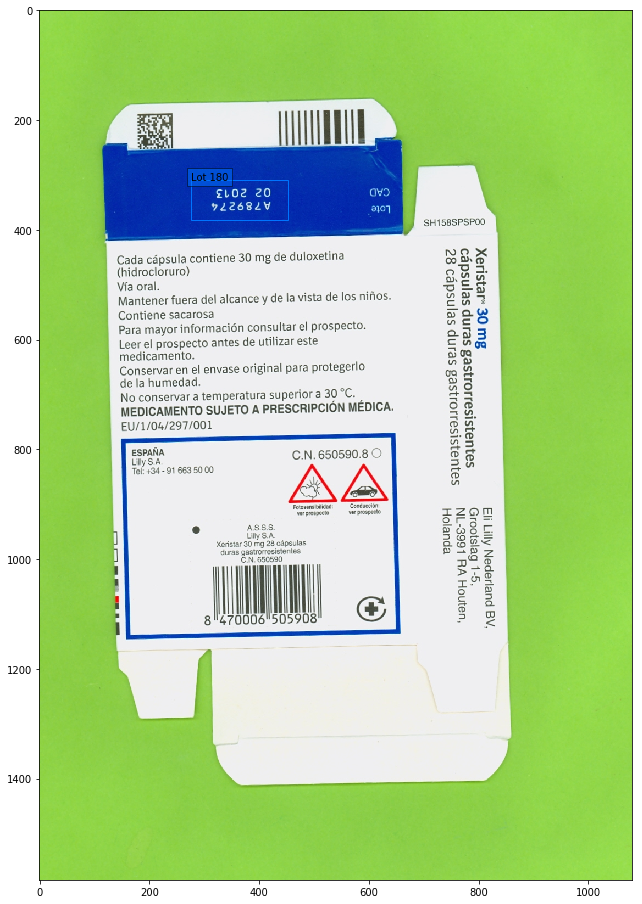

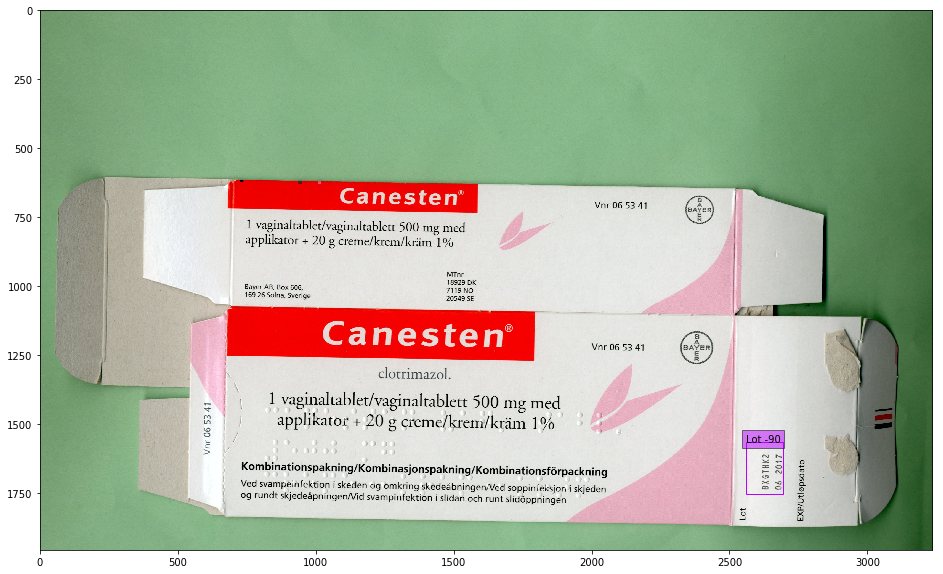

In [11]:
import matplotlib.pyplot as plt

for i in range(2):
    #idx, img, gt = gt_util.sample(i)
    idx, img, gt = gt_util.sample()
    plt.figure(figsize=[16]*2)
    plt.imshow(img)
    gt_util.plot_gt(gt)
    #plt.savefig('gt_%03d.jpg' % (i))
    plt.show()